In [106]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers

In [107]:
syscov = np.loadtxt('data/pantheon_errors.txt',skiprows=1).reshape((1048,1048))
print(np.min(syscov), np.max(syscov), np.mean(syscov))

-0.00033653 0.00362865 8.662339843977609e-08


In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
            print(i,j)
            print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

358 820
8.16e-05 8.1595e-05
517 810
3.7935e-05 3.794e-05
517 957
3.7935e-05 3.794e-05


3

In [17]:
file = 'data/pantheon.txt'
data = pd.read_csv(file, sep = " " ,usecols=['zcmb', 'dmb'] )
# X = data.values[:,0]
staterr = data.values[:,1]

In [18]:
covfull = np.copy(syscov)
covfull[np.diag_indices_from(covfull)] += staterr**2
print(np.shape(syscov), np.shape(covfull))
mincov = np.min(covfull)
maxcov = np.max(covfull)
meancov = np.mean(covfull)
print(mincov, maxcov, meancov)

(1048, 1048) (1048, 1048)
-0.00033653 0.20346321749999996 2.0207316428329494e-05


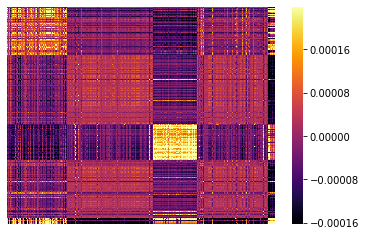

In [7]:
# df_syscov = pd.DataFrame(syscov)
# sns.heatmap(df_syscov, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno',
#             robust=True)

# plt.savefig("cov_sys.png", dpi=300)

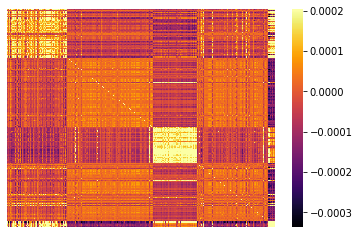

In [8]:
df_covfull = pd.DataFrame(covfull)
sns.heatmap(df_covfull, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno',
            vmax=maxcov/1e3, vmin=mincov,robust=True)
# cmaps['Perceptually Uniform Sequential'] = [
#             'viridis', 'plasma', 'inferno', 'magma', 'cividis']
# cmaps['Sequential'] = [
#             'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
#             'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
#             'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
# cmaps['Sequential (2)'] = [
#             'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
#             'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
#             'hot', 'afmhot', 'gist_heat', 'copper']


In [9]:
# Y = syscov
# # print(np.shape(dataFull))
# # randomize = np.random.permutation(len(data.values))
# shuffle = [x for x in range(len(data.values)) if x%2==0]
# odd = [x for x in range(len(data.values)) if x%2==0]
# shuffle.extend(odd)

# X = X[shuffle]
# y = Y[shuffle]

# scalerx = StandardScaler()
# scalerx.fit(X.reshape(-1,1))
# X = scalerx.transform(X.reshape(-1,1))

# # scalery = StandardScaler()
# # scalery.fit(X.reshape(-1,1))
# # Y = scalerx.transform(Y.reshape(-1,1))

# split = 0.8
# ntrain = int(split * len(X))
# indx = [ntrain]
# X_train, X_test = np.split(X, indx)
# y_train, y_test = np.split(y, indx)
# print(np.shape(syscov))

(1048, 1048)


In [10]:
np.min(syscov.diagonal()) #checking non-negatives

3.5145e-05

In [11]:
syscov[0,1] == syscov[1,0]

True

In [12]:
np.min(syscov)

-0.00033653

In [39]:
# eigenval, eigenvec = sp.linalg.eigh(syscov)
eigenval, eigenvec = sp.linalg.eigh(covfull)

In [40]:
np.shape(eigenval), np.shape(eigenvec)

((1048,), (1048, 1048))

The eigenvalues are positive?

In [41]:
np.min(eigenval)

0.007366201584948819

In [42]:
count = 0

for i in range(len(eigenvec)):
    for j in range(len(eigenvec)):
        if np.iscomplex(eigenvec[i,j]):
#             print("COMPLEX")
            count+=1
#             print(i,j)
#             print(eigenvec[i,j])

print(count)

0


In [43]:
def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q

In [44]:
ortM = np.array(gram_schmidt_columns(np.real(eigenvec)))

In [45]:
np.shape(ortM)

(1048, 1048)

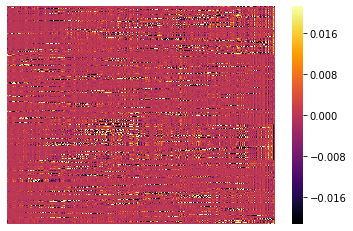

In [46]:
sns.heatmap(pd.DataFrame(ortM), annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno', 
            robust=True)

In [47]:
Y = ortM

In [48]:
# model = tf.keras.models.Sequential([
# #         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(200, activation=tf.nn.relu, input_shape=(1,)),
# #         tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
#         tf.keras.layers.Dense(200, activation=tf.nn.relu),
# #         tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
#         tf.keras.layers.Dense(200, activation=tf.nn.relu),
# #         tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
#         tf.keras.layers.Dense(1048)
#     ])
                              
# model.compile(
#         optimizer='adam',
#         loss='mean_squared_error',
#         metrics=['mean_squared_error']
#       )

# model_train = model.fit(X_train, y_train, epochs=200, 
#           batch_size=64,verbose=1, validation_data=(X_test, y_test)) 

In [49]:
# plt.plot(model_train.history['loss'], color='r', )
# plt.plot(model_train.history['val_loss'], color='g')
# # plt.title('model loss function')
# plt.ylabel('MSE')
# plt.xlabel('Epochs')
# plt.legend(['train', 'val'], loc='upper left')
# # plt.savefig("loss_COVsn.png", dpi=200)

In [50]:
# np.max(model_train.history['val_loss'])

In [51]:
# r = np.random.uniform(0, 2.0, size=1048)
# rs = scalerx.transform(r.reshape(-1,1))
# pred_random = model.predict(rs)

In [52]:
# pred_random = pred_random[:,:1048]
# df_pred = pd.DataFrame(pred_random)
# # sns.heatmap(df_pred, annot=True, fmt='g')
# sns.heatmap(df_pred, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno', 
#             robust=True)

In [53]:
# pred_random[81,:]


In [54]:
np.mean(eigenvec)

3.38101536716499e-07

In [227]:
input_cov = Input(shape=(1048,))
encoded1 = Dense(100, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_cov)
encoded2 = Dense(20, activation='relu',  activity_regularizer=regularizers.l1(10e-5))(encoded1)
# encoded3 = Dense(50, activation='relu',  activity_regularizer=regularizers.l1(10e-5))(encoded2)
# encoded4 = Dense(10, activation='relu',  activity_regularizer=regularizers.l1(10e-5))(encoded3)
# encoded5 = Dense(5, activation='relu',  activity_regularizer=regularizers.l1(10e-5))(encoded4)

coded = Dense(1, activation='relu',  activity_regularizer=regularizers.l1(10e-5))(encoded2)

decoded1 = Dense(20, activation='relu',  activity_regularizer=regularizers.l1(10e-5))(coded)
decoded2 = Dense(100, activation='relu',  activity_regularizer=regularizers.l1(10e-5))(decoded1)
# decoded3 = Dense(50, activation='relu',  activity_regularizer=regularizers.l1(10e-5))(decoded2)
# decoded4 = Dense(100, activation='relu',  activity_regularizer=regularizers.l1(10e-5))(decoded3)
# decoded5 = Dense(200, activation='relu')(decoded4)
decoded_out = Dense(1048, activation='relu')(decoded2)


In [228]:
split = 0.8
ntrain = int(split * len(eigenvec))
indx = [ntrain]
eigscaler = StandardScaler()
eigenvec *= 1e10 
# eigscaler = Stan(feature_range=(-1, 1))
eigscaler.fit(eigenvec)
eigenvec = eigscaler.transform(eigenvec)
evec_train, evec_test = np.split(eigenvec, indx)
evec_train, evec_test = np.split(eigenvec, indx)

autoencoder = Model(input_cov, decoded_out)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_train = autoencoder.fit(evec_train, evec_train,
                epochs=30,
                batch_size=8,
                shuffle=True,
                validation_data=(evec_test, evec_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/30
105/105 [==============================] - 0s 3ms/step - loss: 1.0062 - val_loss: 1.0065
Epoch 2/30
105/105 [==============================] - 0s 2ms/step - loss: 1.0041 - val_loss: 1.0074
Epoch 3/30
105/105 [==============================] - 0s 2ms/step - loss: 1.0026 - val_loss: 1.0082
Epoch 4/30
105/105 [==============================] - 0s 2ms/step - loss: 1.0015 - val_loss: 1.0088
Epoch 5/30
105/105 [==============================] - 0s 2ms/step - loss: 1.0006 - val_loss: 1.0092
Epoch 6/30
105/105 [==============================] - 0s 2ms/step - loss: 1.0002 - val_loss: 1.0095
Epoch 7/30
105/105 [==============================] - 0s 2ms/step - loss: 0.9999 - val_loss: 1.0097
Epoch 8/30
105/105 [==============================] - 0s 2ms/step - loss: 0.9998 - val_loss: 1.0097
Epoch 9/30
105/105 [==============================] - 0s 2ms/step - loss: 0.9998 - val_loss: 1.0098
Epoch 10/30
105/105 [==============================] - 0s 2ms/step - loss: 0.9996 - val_loss: 1.0098

In [229]:
autoencoder.summary()

Model: "functional_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        [(None, 1048)]            0         
_________________________________________________________________
dense_266 (Dense)            (None, 100)               104900    
_________________________________________________________________
dense_267 (Dense)            (None, 20)                2020      
_________________________________________________________________
dense_268 (Dense)            (None, 1)                 21        
_________________________________________________________________
dense_269 (Dense)            (None, 20)                40        
_________________________________________________________________
dense_270 (Dense)            (None, 100)               2100      
_________________________________________________________________
dense_271 (Dense)            (None, 1048)           

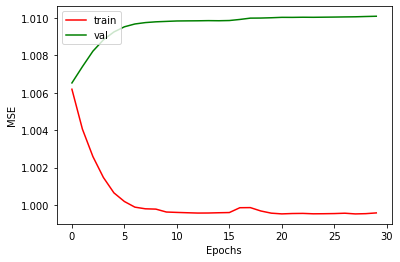

In [230]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')

In [231]:
# r = np.random.uniform(0, 2.0, size=1048)
# rs = eigscaler.transform(r.reshape(-1,1))
# pred_random = autoencoder.predict(rs)
# pred_random = pred_random[:,:1048]
# df_pred = pd.DataFrame(pred_random)
# # sns.heatmap(df_pred, annot=True, fmt='g')
# sns.heatmap(df_pred, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno', 
#             robust=True)

In [239]:
encoder = Model(input_cov, encoded2)
encoded_vals = encoder.predict(evec_test)
encoded_vals[0]
evec_train

array([[-9.96436282e-02,  3.52957420e-03, -1.33847277e-01, ...,
         2.26255475e-01, -2.49138973e-01, -3.00513916e-02],
       [-1.00228134e-01,  4.67825938e-03, -1.21116279e-01, ...,
         1.53728888e-01, -1.63763382e-01, -3.15895964e-02],
       [-2.30696354e-02,  2.21954678e-02, -8.82789354e-02, ...,
         2.44186274e-01, -3.72678282e-01, -5.01094965e-02],
       ...,
       [-3.83254511e-03,  3.11619871e-02, -3.36703646e-02, ...,
        -3.21004031e-01,  3.81366946e-01, -4.74990110e-02],
       [-2.48334473e-04,  1.66877505e-02,  1.80981628e-02, ...,
        -3.15391824e-01,  3.73267437e-01, -5.09184477e-02],
       [-1.06207426e-02,  4.76135751e-02, -4.16807631e-02, ...,
        -2.68768455e-01,  3.72315568e-01, -3.72503458e-02]])

In [264]:
encoding_dim =1
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(1,))
encoded_input

<tf.Tensor 'input_56:0' shape=(None, 1) dtype=float32>

In [265]:
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-3]
decoder_layer

In [267]:
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [270]:
#The decoder model
encoding_dim = 1
encoded_input = Input(shape=(encoding_dim,), name='encoded_input')
new_decoded_1 = autoencoder.layers[-3](encoded_input)
new_decoded_2 = autoencoder.layers[-2](new_decoded_1)
new_decoded_3 = autoencoder.layers[-1](new_decoded_2)

decoder = Model(encoded_input, new_decoded_3)

In [271]:
decoder.summary()

Model: "functional_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_input (InputLayer)   [(None, 1)]               0         
_________________________________________________________________
dense_269 (Dense)            (None, 20)                40        
_________________________________________________________________
dense_270 (Dense)            (None, 100)               2100      
_________________________________________________________________
dense_271 (Dense)            (None, 1048)              105848    
Total params: 107,988
Trainable params: 107,988
Non-trainable params: 0
_________________________________________________________________


In [273]:
decoder.predict([1, 2])

array([[0.        , 0.        , 0.        , ..., 0.19095741, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.39224428, 0.        ,
        0.        ]], dtype=float32)